In [19]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as m
from math import sqrt
import holidays
from sklearn import feature_selection as fs
from sklearn import model_selection as ms
import numpy.random as nr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pickle
from array import array
import random as rn
import itertools

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#read in data
data = pd.read_csv("drive/MyDrive/Colab Notebooks/dscapstone/aemo_wu_merged2.csv")
timeextract = pd.read_csv("drive/MyDrive/Colab Notebooks/dscapstone/aemo_wu_merged1.csv")

In [22]:
#Using a long winded middle join to deal with the worst feature ever implemented in python - automatic exclusion of nuisance columns
#which is trying to delete my wind column
data['timestamp'] = pd.to_datetime(data['timestamp'])
timeextract['timestamp'] = pd.to_datetime(timeextract['timestamp'])
data1 = data
data =data.groupby(pd.Grouper(key='timestamp', freq='30min')).mean().dropna()
timeextract=timeextract[['timestamp', 'Operational Demand (MW)']]
df_merged = pd.merge_asof(data.sort_values('timestamp'),timeextract.sort_values('timestamp'), on='timestamp',allow_exact_matches=True)
data2 = data1[['timestamp', 'Wind']]
data2['timestamp'] = pd.to_datetime(data2['timestamp'])
data = pd.merge(df_merged, data2, on='timestamp', how='inner')
data.pop('Operational Demand (MW)_x')
data = data.rename(columns={'Operational Demand (MW)_y': 'Operational Demand (MW)'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Feature Engineering

In [23]:
#consolidate data into hourly instead of half hourly
data = data.iloc[:-1 , :]
data = data.iloc[1: , :]
df1 = data[data.index % 2 != 0]
df2 = data[data.index % 2 == 0]
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

df1demand = df1.pop('Operational Demand (MW)')
df2demand = df2.pop('Operational Demand (MW)')
total_demand = df1demand+df2demand
data = df2.join(total_demand)

In [24]:
#remove columns with bad data, high co-correlation, little impact, or low p values
data = data.drop(columns = ['Unnamed: 0', 'Precip.', 'Wind Gust', 'Humidity'])

In [25]:
#Feature Engineering time data
data['date'] = pd.to_datetime(data.pop('timestamp'), format='%Y.%m.%d %H:%M:%S')
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.dayofyear
data['week'] = data['date'].dt.week
data['month'] = data['date'].dt.month
data['weekday'] = data['date'].dt.day_name()

#check whether any given day is a holiday in Western Australia
WA_holidays = holidays.AU(subdiv='WA')
data['holiday'] = [1 if x in WA_holidays else 0 for x in data['date']]

#creating new indicator variable which informs whether any given day is a working day
data['isWorkDay'] = data.apply(lambda x: 'no' if ((x['holiday'] == 1) or
                                             (x['weekday'] in ['Saturday', 'Sunday'])) else 'yes', axis=1)
workdaybin = pd.get_dummies(data["isWorkDay"])
WorkingDay = workdaybin['yes']
data = data.join(WorkingDay)
data.rename(columns = {'yes':'WorkingDay'}, inplace = True)

#drop date cols which will not be used in the model
data = data.drop(columns = ['holiday', 'weekday', 'isWorkDay', 'day'])

#change new date columns into categorical variables
cat_cols = ['hour','week','month','WorkingDay']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


Creating a vector variable from wind direction and speed



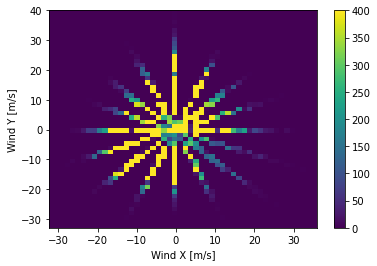

In [26]:
#Function to transform categorical wind direction into angle
def dir_to_degrees(dir):
  ang = 22.5
  if dir == 'N':
    dir = ang*0
  elif dir == 'NNE':
    dir = ang*1
  elif dir == 'NE':
    dir = ang*2
  elif dir == 'ENE':
    dir = ang*3
  elif dir == 'E':
    dir = ang*4
  elif dir == 'ESE':
    dir = ang*5
  elif dir == 'SE':
    dir = ang*6
  elif dir == 'SSE':
    dir = ang*7
  elif dir == 'S':
    dir = ang*8
  elif dir == 'SSW':
    dir = ang*9
  elif dir == 'SW':
    dir = ang*10
  elif dir == 'WSW':
    dir = ang*11
  elif dir == 'W':
    dir = ang*12
  elif dir == 'WNW':
    dir = ang*13
  elif dir == 'NW':
    dir = ang*14
  elif dir == 'NNW':
    dir = ang*15
  elif dir == 'CALM' or 'VAR':
    dir = 0
  return dir
#applying above function
data['Wind'] = data['Wind'].map(dir_to_degrees)

#collecting wind speed variable
wv = data.pop('Wind Speed')

# Convert degrees column created with above function to radians.
wd_rad = data.pop('Wind')*np.pi / 180

# Calculate the wind x and y components using radians and wind speed
data['Wx'] = wv*np.cos(wd_rad)
data['Wy'] = wv*np.sin(wd_rad)

#visualise new wind vector
plt.hist2d(data['Wx'], data['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

Renaming columns to more suitable names

In [27]:
data = data.rename({'Temperature': 'Temp', 'Operational Demand (MW)':'Demand', 'Dew Point': 'dew_point', 'Pressure': 'pressure'}, axis=1)

Create Metric assessment function

In [28]:
#creating metrics to measure model performance
def metricf(fcast, test):
  mae = m.mean_absolute_error(test,fcast)
  print('MAE : %3f' % mae)
  mse = m.mean_squared_error(test,fcast)
  print('MSE : %3f' % mse)
  rmse = sqrt(mse)
  print('RMSE : %3f' % rmse)
  mape = m.mean_absolute_percentage_error(test,fcast)
  print('MAPE : %3f' % mape)

In [29]:
# Function to plot graph of last 3 days of summer predictions vs Actual
def plot_result(ypred, yactual, model_name = None):
  pred = np.stack([i for i in ypred]).reshape(-1,1)
  tester = np.stack([i for i in test]).reshape(-1,1)
  pred = pd.DataFrame(pred)
  tester = pd.DataFrame(tester)
  result = pd.concat([pred, tester],ignore_index=True, axis=1)
  plt.figure(figsize=(25,18))
  plt.plot(result[-72:][0], color = 'blue', label="Forecasted Demand")
  plt.plot(result[-72:][1],color = 'green', label="Actual Demand")
  plt.legend(loc='upper left')
  plt.title('Forecasted and Actual Demand of {}'.format(model_name))
  plt.xlabel('Hours')
  plt.ylabel('Demand')
  print('Accuracy: {}'.format(m.r2_score(pred, tester)))

Adding 24 Hours of Energy Demand Lag Features to each observation

In [30]:
#set index on date
lag_df = data.set_index('date')

#remove all dates after 2022-03-01
lag_df = lag_df[:'2022-03-01']
lag_df= lag_df[:-24]
# getting 24 hours lag
for i in range(24):
  lag_df['lag' + str(i+1)] = lag_df['Demand'].shift(i+1)
#drop the first 24 hours NaN values
lag = lag_df.dropna()

In [31]:
#taking way too long to train so removed some early data between 2006 and 2010.
lag = lag[30000:]

In [32]:
lag

,Temp,dew_point,pressure,Demand,hour,week,month,WorkingDay,Wx,Wy,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
date,,,,,,,,,,,,,,,,,,,,,
2010-04-05 10:30:00,21.11,12.22,29.0,3485.316,10,14,4,0,2.000000e+00,0.000000,...,3634.976,3431.282,3358.460,3316.372,3320.590,3372.156,3397.280,3400.990,3368.176,3222.568
2010-04-05 11:30:00,21.11,12.22,29.0,3511.746,11,14,4,0,-5.543277e+00,-2.296101,...,3862.282,3634.976,3431.282,3358.460,3316.372,3320.590,3372.156,3397.280,3400.990,3368.176
2010-04-05 12:30:00,22.22,12.22,29.0,3519.910,12,14,4,0,-1.469576e-15,-8.000000,...,3727.924,3862.282,3634.976,3431.282,3358.460,3316.372,3320.590,3372.156,3397.280,3400.990
2010-04-05 13:30:00,22.78,12.78,29.0,3477.010,13,14,4,0,-1.836970e-15,-10.000000,...,3529.282,3727.924,3862.282,3634.976,3431.282,3358.460,3316.372,3320.590,3372.156,3397.280
2010-04-05 14:30:00,22.22,12.22,29.0,3487.798,14,14,4,0,-3.444151e+00,-8.314916,...,3318.908,3529.282,3727.924,3862.282,3634.976,3431.282,3358.460,3316.372,3320.590,3372.156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 19:00:00,23.89,17.78,29.0,6236.798,19,9,2,1,-5.357568e+00,-12.934313,...,3999.532,4059.926,4136.738,4264.370,4467.146,4815.184,5284.172,5865.806,6342.066,6627.516
2022-02-28 20:00:00,22.78,17.78,29.0,5887.228,20,9,2,1,-1.060660e+01,-10.606602,...,4132.712,3999.532,4059.926,4136.738,4264.370,4467.146,4815.184,5284.172,5865.806,6342.066
2022-02-28 21:00:00,22.22,17.78,29.0,5420.106,21,9,2,1,-9.238795e+00,-3.826834,...,4379.884,4132.712,3999.532,4059.926,4136.738,4264.370,4467.146,4815.184,5284.172,5865.806


Set columns to transform (standardise)

In [33]:
#defining scaler
scaler = StandardScaler()

cols = ['Temp','dew_point','pressure', 'Wx','Wy']
lags_list = ['lag' + str(i+1) for i in range(24)]
cols.extend(lags_list)

#applying scaler
lag[cols] = scaler.fit_transform(lag[cols])
lag.insert(0, 'Demand', lag.pop('Demand'))

In [34]:
#Find number of hours during summer
d1 = datetime.date(2022, 3, 1)
d0 = datetime.date(2021, 12, 1)
delta = d1 - d0
print('The number of days between the given range of dates is :')
print(delta.days)
hours = delta.days*24
print('the equivelant number of hours is:')
print(hours)

The number of days between the given range of dates is :
90
the equivelant number of hours is:
2160


In [15]:
#split data into train and test sets
def split_data_fcast(X,y):
  X_train, X_test, y_train, y_test = X[:-90], X[-90:], y[:-90], y[-90:]
  return X_train, X_test, y_train, y_test

In [18]:
#function to split into window of past and future observations
def split_sequence_mult(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ts = i + n_steps_in
    out_ts = end_ts + n_steps_out -1 
    if out_ts > len(sequence):
      break;
    seqx, seqy = sequence.iloc[i:end_ts, 1:], sequence.iloc[end_ts-1:out_ts, 0]
    X.append(seqx)
    y.append(seqy)
  return np.stack(X), np.stack(y)

First Model: MLP

In [35]:
n_steps_in, n_steps_out = 48,24
X, y = split_sequence_mult(lag, n_steps_in=n_steps_in,n_steps_out=n_steps_out)

In [36]:
#flatten inputs for MLP
n_inputs, n_out = X.shape[1] * X.shape[2], 24
XC = X.reshape(X.shape[0], n_inputs)

X_train, X_test, y_train, y_test = split_data_fcast(XC,y)

In [21]:
#save MLP data
np.savetxt('drive/MyDrive/Colab Notebooks/dscapstone/X_trainMLP.txt', X_train, fmt='%d')
np.savetxt('drive/MyDrive/Colab Notebooks/dscapstone/y_trainMLP.txt', y_train, fmt='%d')
np.savetxt('drive/MyDrive/Colab Notebooks/dscapstone/X_testMLP.txt', X_test, fmt='%d')
np.savetxt('drive/MyDrive/Colab Notebooks/dscapstone/y_testMLP.txt', y_test, fmt='%d')

In [7]:
#reload MLP data
X_trainMLP = np.loadtxt('drive/MyDrive/Colab Notebooks/dscapstone/X_trainMLP.txt', dtype=int)
y_trainMLP = np.loadtxt('drive/MyDrive/Colab Notebooks/dscapstone/y_trainMLP.txt', dtype=int)
X_testMLP = np.loadtxt('drive/MyDrive/Colab Notebooks/dscapstone/X_testMLP.txt', dtype=int)
y_testMLP = np.loadtxt('drive/MyDrive/Colab Notebooks/dscapstone/y_testMLP.txt', dtype=int)

In [475]:
#Train MLP Model
rn.seed(15)
tf.random.set_seed(15)

MLP_model = Sequential()
MLP_model.add(Dense(800, activation='relu', input_dim=n_inputs))
MLP_model.add(Dense(n_out))
MLP_model.compile(optimizer='adam', loss='mse')
MLP_model.fit(X_train, y_train, epochs=90, verbose=1)

Epoch 1/90
3196/3196 [==============================] - 30s 9ms/step - loss: 407644.4062
Epoch 2/90
3196/3196 [==============================] - 28s 9ms/step - loss: 120923.8594
Epoch 3/90
3196/3196 [==============================] - 28s 9ms/step - loss: 109715.2344
Epoch 4/90
3196/3196 [==============================] - 27s 9ms/step - loss: 102485.0547
Epoch 5/90
3196/3196 [==============================] - 27s 9ms/step - loss: 97395.0156
Epoch 6/90
3196/3196 [==============================] - 28s 9ms/step - loss: 93836.3750
Epoch 7/90
3196/3196 [==============================] - 30s 9ms/step - loss: 90984.5078
Epoch 8/90
3196/3196 [==============================] - 28s 9ms/step - loss: 88571.8984
Epoch 9/90
3196/3196 [==============================] - 29s 9ms/step - loss: 86197.6641
Epoch 10/90
3196/3196 [==============================] - 28s 9ms/step - loss: 84442.2500
Epoch 11/90
3196/3196 [==============================] - 27s 9ms/step - loss: 82679.4219
Epoch 12/90
3196/3196 [===

In [476]:
#save the model
with open('drive/MyDrive/Colab Notebooks/dscapstone/MLP_model', 'wb') as f:
  pickle.dump(MLP_model,f)

In [5]:
#reload the model
with open('drive/MyDrive/Colab Notebooks/dscapstone/MLP_model', 'rb') as f:
  MLP_model = pickle.load(f)

In [10]:
#model prediction and metrics
MLPypred=MLP_model.predict(X_testMLP)
MLPtest = y_testMLP
metricf(MLPypred, MLPtest)

3/3 [==============================] - 0s 6ms/step
MAE : 324.651057
MSE : 178109.202276
RMSE : 422.029859
MAPE : 0.068723


Accuracy: 0.8098388945568339


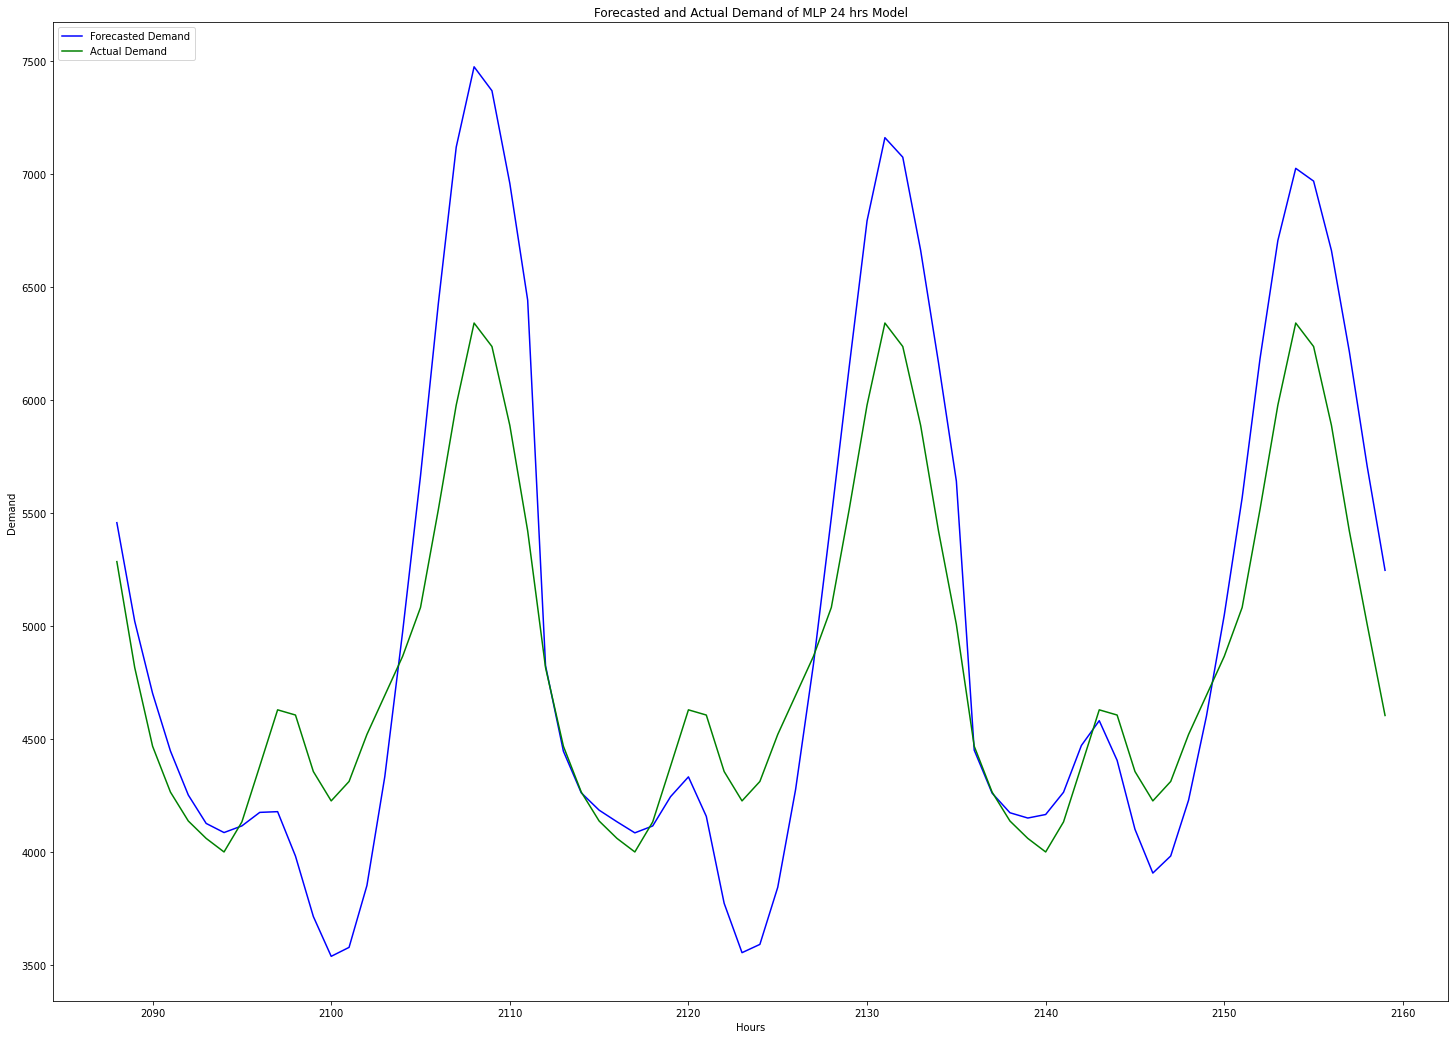

In [34]:
MLPypredlist=list(itertools.chain.from_iterable(MLPypred))
test_list=list(itertools.chain.from_iterable(MLPtest))
plot_result(MLPypredlist, test_list, 'MLP 24 hrs Model')

Second Model: CNN

In [37]:
n_in, n_out = 48, 24
#X,y = split_sequence_mult(lag,n_in, n_out)

X_train, X_test, y_train, y_test = split_data_fcast(X,y)


In [26]:
rn.seed(24)
tf.random.set_seed(24)


n_features = 33
# define model
CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_in,
n_features)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(800, activation='relu'))
CNN_model.add(Dense(n_out))
CNN_model.compile(optimizer='adam', loss='mse')
# fit model
CNN_model.fit(X_train, y_train, epochs=90, verbose=1)

Epoch 1/90
3196/3196 [==============================] - 52s 16ms/step - loss: 347279.7188
Epoch 2/90
3196/3196 [==============================] - 50s 16ms/step - loss: 130197.2500
Epoch 3/90
3196/3196 [==============================] - 48s 15ms/step - loss: 116179.5391
Epoch 4/90
3196/3196 [==============================] - 47s 15ms/step - loss: 107667.6641
Epoch 5/90
3196/3196 [==============================] - 47s 15ms/step - loss: 101807.1328
Epoch 6/90
3196/3196 [==============================] - 49s 15ms/step - loss: 97464.9766
Epoch 7/90
3196/3196 [==============================] - 49s 15ms/step - loss: 93995.9766
Epoch 8/90
3196/3196 [==============================] - 48s 15ms/step - loss: 91243.9609
Epoch 9/90
3196/3196 [==============================] - 50s 16ms/step - loss: 88816.0859
Epoch 10/90
3196/3196 [==============================] - 52s 16ms/step - loss: 86333.3203
Epoch 11/90
3196/3196 [==============================] - 47s 15ms/step - loss: 84031.0156
Epoch 12/90
31

In [27]:
with open('drive/MyDrive/Colab Notebooks/dscapstone/CNN_model', 'wb') as f:
  pickle.dump(CNN_model,f)

In [12]:
with open('drive/MyDrive/Colab Notebooks/dscapstone/CNN_model', 'rb') as f:
  CNN_model = pickle.load(f)

In [38]:
CNNyhat=CNN_model.predict(X_test)
CNNtest = y_test
metricf(CNNyhat, CNNtest)

3/3 [==============================] - 0s 7ms/step
MAE : 274.198372
MSE : 138057.440148
RMSE : 371.560816
MAPE : 0.061753
